In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import os







In [4]:

# CoinGecko API endpoint for USDC market chart
url = "https://api.coingecko.com/api/v3/coins/usd-coin/market_chart"
params = {
    "vs_currency": "usd",
    "days": "365",  # last 30 days
    "interval": "daily"
}


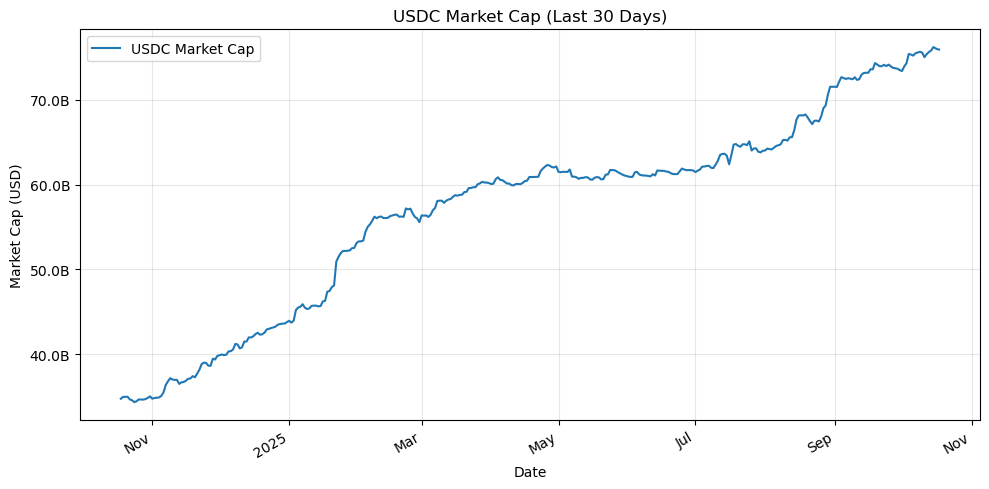

In [5]:

# Make the request
response = requests.get(url, params=params,timeout = 30)
data = response.json()
# Convert market cap data to DataFrame
market_caps = pd.DataFrame(data['market_caps'], columns=['timestamp', 'market_cap'])
market_caps['date'] = pd.to_datetime(market_caps['timestamp'], unit='ms')

# Plot
# Plot (drop‑in replacement)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(market_caps['date'], market_caps['market_cap'], label='USDC Market Cap', color='#1f77b4')

# Fix overlapping dates on the x-axis
locator = mdates.AutoDateLocator(minticks=5, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

#Improved y-axis for big numbers (K/M/B)
ax.yaxis.set_major_formatter(FuncFormatter(
    lambda x, pos: f'{x/1e9:.1f}B' if abs(x) >= 1e9 else
                   f'{x/1e6:.1f}M' if abs(x) >= 1e6 else
                   f'{x/1e3:.0f}K' if abs(x) >= 1e3 else
                   f'{x:.0f}'
))

ax.set_title('USDC Market Cap (Last 30 Days)')
ax.set_xlabel('Date')
ax.set_ylabel('Market Cap (USD)')
ax.legend()
ax.grid(True, alpha=0.3)

fig.autofmt_xdate()   # gentle rotation if needed
plt.tight_layout()
plt.show()

In [7]:
#Created helper method to print out error codes for troubleshooting
print("HTTP status:", response.status_code)

try:
    data = response.json()
except ValueError:
    print("Non-JSON response (first 500 chars):\n", response.text[:500])
    raise

print("Top-level keys:", list(data.keys()))
print("Sample payload:", str(data)[:500])  # peek

HTTP status: 200
Top-level keys: ['prices', 'market_caps', 'total_volumes']
Sample payload: {'prices': [[1729209600000, 1.0000519041903995], [1729296000000, 1.000306610654406], [1729382400000, 0.9999945031446472], [1729468800000, 1.0000566123623522], [1729555200000, 0.9995741903751171], [1729641600000, 0.9998844803689325], [1729728000000, 1.0000200383373299], [1729814400000, 1.0005753419089458], [1729900800000, 1.001684712545052], [1729987200000, 0.999830678858966], [1730073600000, 0.9996665695853105], [1730160000000, 0.9999192104430895], [1730246400000, 1.0008283509700115], [173033280


In [17]:
# Load FRED API key from environment variables
FRED_API_KEY = os.getenv("FRED_API_KEY")

# Base URL for FRED API observations endpoint
FRED = "https://api.stlouisfed.org/fred/series/observations"

# Function to fetch and clean FRED data for a given series
def fred_json(series_id, start="2024-01-01"):
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "observation_start": start
    }
    # Make the GET request to FRED API
    r = requests.get(FRED, params=params, timeout=30)
    r.raise_for_status()
    # Extract observations from JSON response
    obs = r.json()["observations"]
    # Create a DataFrame from the observations, keeping only 'date' and 'value' columns
    df = pd.DataFrame(obs)[["date","value"]]
    # Convert the 'value' column from string to numeric, coercing errors to NaN
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    # Convert the 'date' column from string to datetime format
    df["date"] = pd.to_datetime(df["date"])
    # Rename the 'value' column to the series_id for clarity (e.g., 'SOFR', 'DGS3MO')
    # Set 'date' as the index to enable time series operations
    # Sort the DataFrame by date to ensure chronological order
    return df.rename(columns={"value": series_id}).set_index("date").sort_index()

start_date = market_caps["date"].min().strftime("%Y-%m-%d")  # align to your USDC window (365d)
deposits = fred_json("DPSACBW027SBOG", start=start_date)   # Weekly SA
t3m     = fred_json("DGS3MO", start=start_date)            # Daily
sofr    = fred_json("SOFR", start=start_date)              # Daily
onrrp   = fred_json("RRPONTSYD", start=start_date)         # Daily (billions USD)


In [19]:
# USDC df cleanup
usdc = market_caps[["date","market_cap"]].copy()
usdc = usdc.set_index("date").sort_index()

# Create a daily index based on USDC's date range
daily_idx = usdc.index  # use USDC's daily dates

# Align other datasets to USDC's daily index using forward fill
# This ensures all dataframes share the same date index for merging
deposits_daily = deposits.reindex(daily_idx, method="ffill")# Weekly → Daily
t3m_daily     = t3m.reindex(daily_idx, method="ffill")#daily already but ensures alignment
sofr_daily    = sofr.reindex(daily_idx, method="ffill")# Daily
onrrp_daily   = onrrp.reindex(daily_idx, method="ffill")# Daily

merged = pd.concat([usdc, deposits_daily, t3m_daily, sofr_daily, onrrp_daily], axis=1)

In [21]:
# Normalize each column in the merged DataFrame to start at 100 for comparison
norm = merged.apply(lambda s: 100 * s / s.dropna().iloc[0])

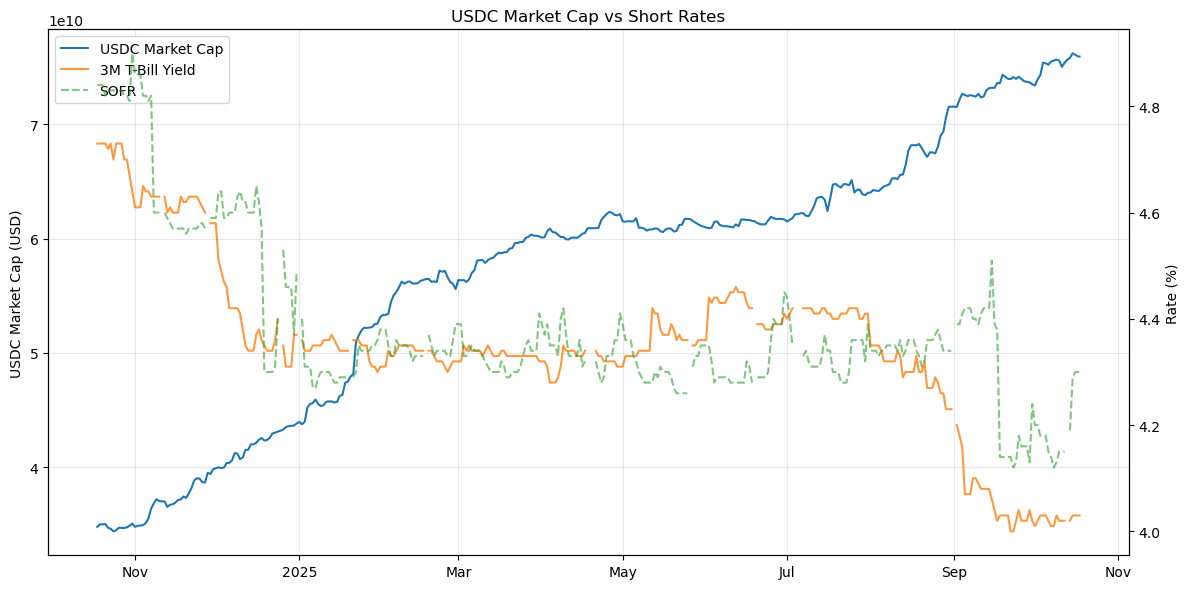

In [23]:
# Create a matplotlib figure and primary axis
fig, ax = plt.subplots(figsize=(12,6))
# Plot USDC market cap on the primary y-axis
ax.plot(merged.index, merged["market_cap"], label="USDC Market Cap", color="#1f77b4")

# Create a secondary y-axis to plot interest rates
ax2 = ax.twinx()
# Plot 3-month Treasury yield on the secondary axis
ax2.plot(merged.index, merged["DGS3MO"], label="3M T-Bill Yield", color="#ff7f0e", alpha=0.8)
ax2.plot(merged.index, merged["SOFR"], label="SOFR", color="#2ca02c", alpha=0.6, linestyle="--")

# Smart dates
locator = mdates.AutoDateLocator(minticks=6, maxticks=10)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

ax.set_title("USDC Market Cap vs Short Rates")
ax.set_ylabel("USDC Market Cap (USD)")
ax2.set_ylabel("Rate (%)")
ax.grid(True, alpha=0.3)

# Legends
lns = ax.get_lines() + ax2.get_lines()
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper left")

plt.tight_layout(); plt.show()


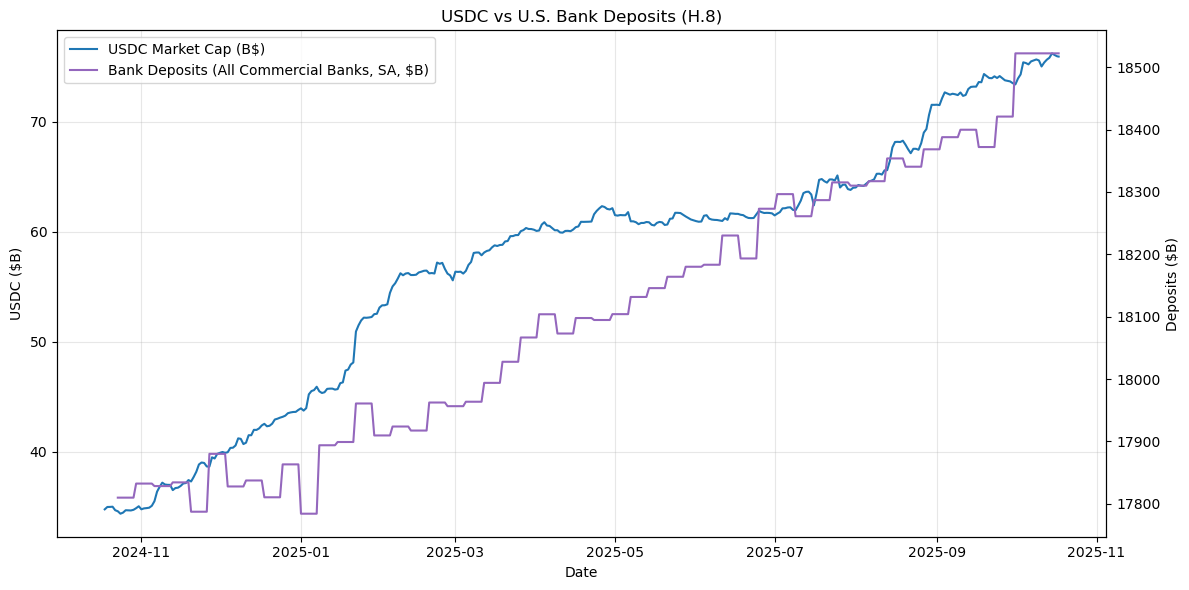

In [25]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(merged.index, merged["market_cap"]/1e9, label="USDC Market Cap (B$)", color="#1f77b4")
ax2 = ax.twinx()
ax2.plot(merged.index, merged["DPSACBW027SBOG"], label="Bank Deposits (All Commercial Banks, SA, $B)", color="#9467bd")

ax.set_title("USDC vs U.S. Bank Deposits (H.8)")
ax.set_xlabel("Date"); ax.set_ylabel("USDC ($B)"); ax2.set_ylabel("Deposits ($B)")
ax.grid(True, alpha=0.3)

lns = ax.get_lines() + ax2.get_lines()
ax.legend(lns, [l.get_label() for l in lns], loc="upper left")
plt.tight_layout(); plt.show()

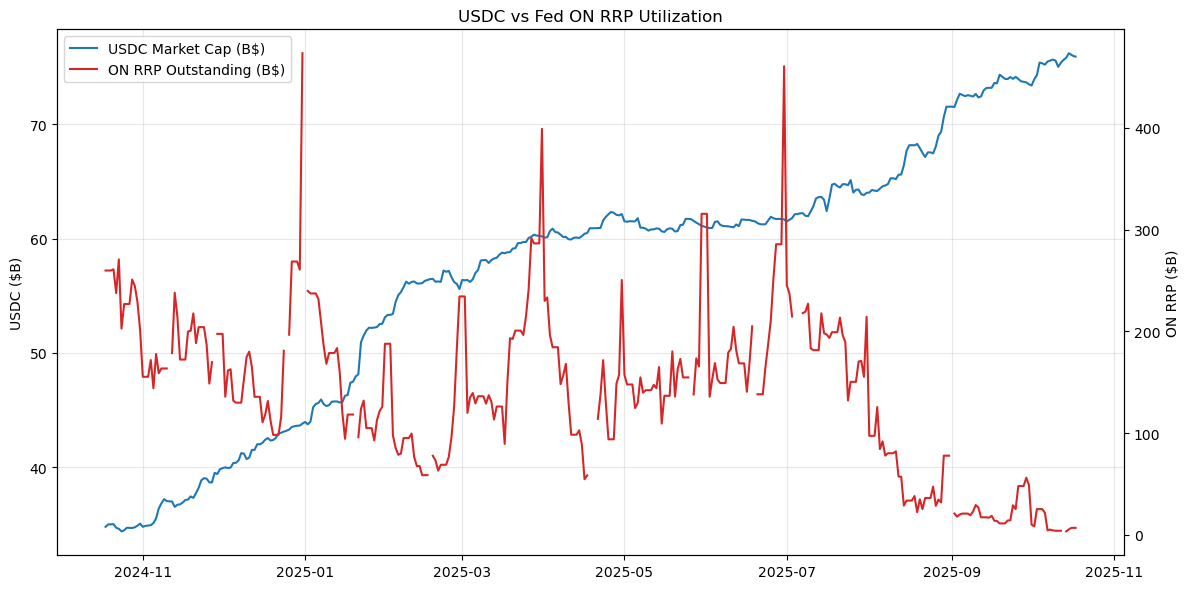

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(merged.index, merged["market_cap"]/1e9, label="USDC Market Cap (B$)")
ax2 = ax.twinx()
ax2.plot(merged.index, merged["RRPONTSYD"], label="ON RRP Outstanding (B$)", color="#d62728")

ax.set_title("USDC vs Fed ON RRP Utilization")
ax.set_ylabel("USDC ($B)"); ax2.set_ylabel("ON RRP ($B)")
ax.grid(True, alpha=0.3)
lns = ax.get_lines() + ax2.get_lines()
ax.legend(lns, [l.get_label() for l in lns], loc="upper left")
plt.tight_layout(); plt.show()

In [ ]:


''' plt.rcParams['figure.dpi'] = 160
FRED_API_KEY = os.getenv("FRED_API_KEY")
FRED_URL = "https://api.stlouisfed.org/fred/series/observations"

def fred_json(series_id, start="2024-01-01"):
    if not FRED_API_KEY:
        raise EnvironmentError("FRED_API_KEY is not set. Export it or set os.environ['FRED_API_KEY']=... and restart the kernel.")
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "observation_start": start
    }
    r = requests.get(FRED_URL, params=params, timeout=30)
    if r.status_code != 200:
        print("URL:", r.url)
        print("Body:", r.text[:600])
        r.raise_for_status()
    payload = r.json()
    if "observations" not in payload:
        raise ValueError(f"Unexpected FRED payload: {str(payload)[:300]}")
    obs = payload["observations"]
    if not obs:
        raise ValueError(f"No observations for {series_id} starting {start}")
    df = pd.DataFrame(obs)[["date","value"]]
    df["date"] = pd.to_datetime(df["date"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    return df.rename(columns={"value": series_id}).set_index("date").sort_index()

def billions_fmt(x, pos):
    if abs(x) >= 1e12: return f"{x/1e12:.1f}T"
    if abs(x) >= 1e9:  return f"{x/1e9:.1f}B"
    if abs(x) >= 1e6:  return f"{x/1e6:.1f}M"
    return f"{x:,.0f}"

def setup_dates(ax, minticks=6, maxticks=10):
    loc = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))


In [29]:
# Set default plot resolution for clearer visuals
plt.rcParams['figure.dpi'] = 160

# Load FRED API key from environment variables
FRED_API_KEY = os.getenv("FRED_API_KEY")

# Base URL for FRED observations API
FRED_URL = "https://api.stlouisfed.org/fred/series/observations"

# Function to fetch and clean FRED data for a given series
def fred_json(series_id, start="2024-01-01"):
    # Raise error if API key is missing
    if not FRED_API_KEY:
        raise EnvironmentError("FRED_API_KEY is not set. Export it or set os.environ['FRED_API_KEY']=... and restart the kernel.")
    
    # Define request parameters
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "observation_start": start
    }

    # Make GET request to FRED API
    r = requests.get(FRED_URL, params=params, timeout=30)

    # If request fails, print debug info and raise error
    if r.status_code != 200:
        print("URL:", r.url)
        print("Body:", r.text[:600])
        r.raise_for_status()

    # Parse JSON response
    payload = r.json()

    # Validate expected structure
    if "observations" not in payload:
        raise ValueError(f"Unexpected FRED payload: {str(payload)[:300]}")

    # Extract observations list
    obs = payload["observations"]

    # Raise error if no data returned
    if not obs:
        raise ValueError(f"No observations for {series_id} starting {start}")

    # Create DataFrame with date and value columns
    df = pd.DataFrame(obs)[["date", "value"]]

    # Convert date strings to datetime objects
    df["date"] = pd.to_datetime(df["date"])

    # Convert value strings to numeric, coercing errors to NaN
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    # Rename value column to series_id, set date as index, and sort chronologically
    return df.rename(columns={"value": series_id}).set_index("date").sort_index()

# Formatter function to display large numbers in billions/trillions
def billions_fmt(x, pos):
    if abs(x) >= 1e12: return f"{x/1e12:.1f}T"
    if abs(x) >= 1e9:  return f"{x/1e9:.1f}B"
    if abs(x) >= 1e6:  return f"{x/1e6:.1f}M"
    return f"{x:,.0f}"

# Function to set smart date formatting on x-axis of a plot
def setup_dates(ax, minticks=6, maxticks=10):
    loc = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))

In [33]:
# Use your USDC date range
usdc = market_caps[["date", "market_cap"]].dropna().copy()
usdc = usdc.set_index("date").sort_index()

start_date = (usdc.index.min() - pd.Timedelta(days=14)).strftime("%Y-%m-%d")

# Fetch series
deposits = fred_json("DPSACBW027SBOG", start=start_date)  # Bank deposits (All Commercial Banks, Weekly, SA)
t3m      = fred_json("DGS3MO",          start=start_date)  # 3M T-bill yield (%)
sofr     = fred_json("SOFR",            start=start_date)  # SOFR (%)
onrrp    = fred_json("RRPONTSYD",       start=start_date)  # ON RRP (Billions USD)

# Align to daily USDC index (forward-fill weekly/daily gaps)
daily_idx = usdc.index
aligned = pd.concat([
    usdc,
    deposits.reindex(daily_idx, method="ffill"),
    t3m.reindex(daily_idx, method="ffill"),
    sofr.reindex(daily_idx, method="ffill"),
    onrrp.reindex(daily_idx, method="ffill")
], axis=1)

aligned.columns = ["usdc_mcap", "bank_deposits", "t3m_yield", "sofr", "on_rrp"]

# Basic sanity print
aligned.tail(3)

,usdc_mcap,bank_deposits,t3m_yield,sofr,on_rrp
date,,,,,
2025-10-16 00:00:00,7.606694e+10,18522.3097,4.03,4.3,6.96
2025-10-17 00:00:00,7.594874e+10,18522.3097,4.03,4.3,6.96
2025-10-17 12:48:56,7.592714e+10,18522.3097,4.03,4.3,6.96


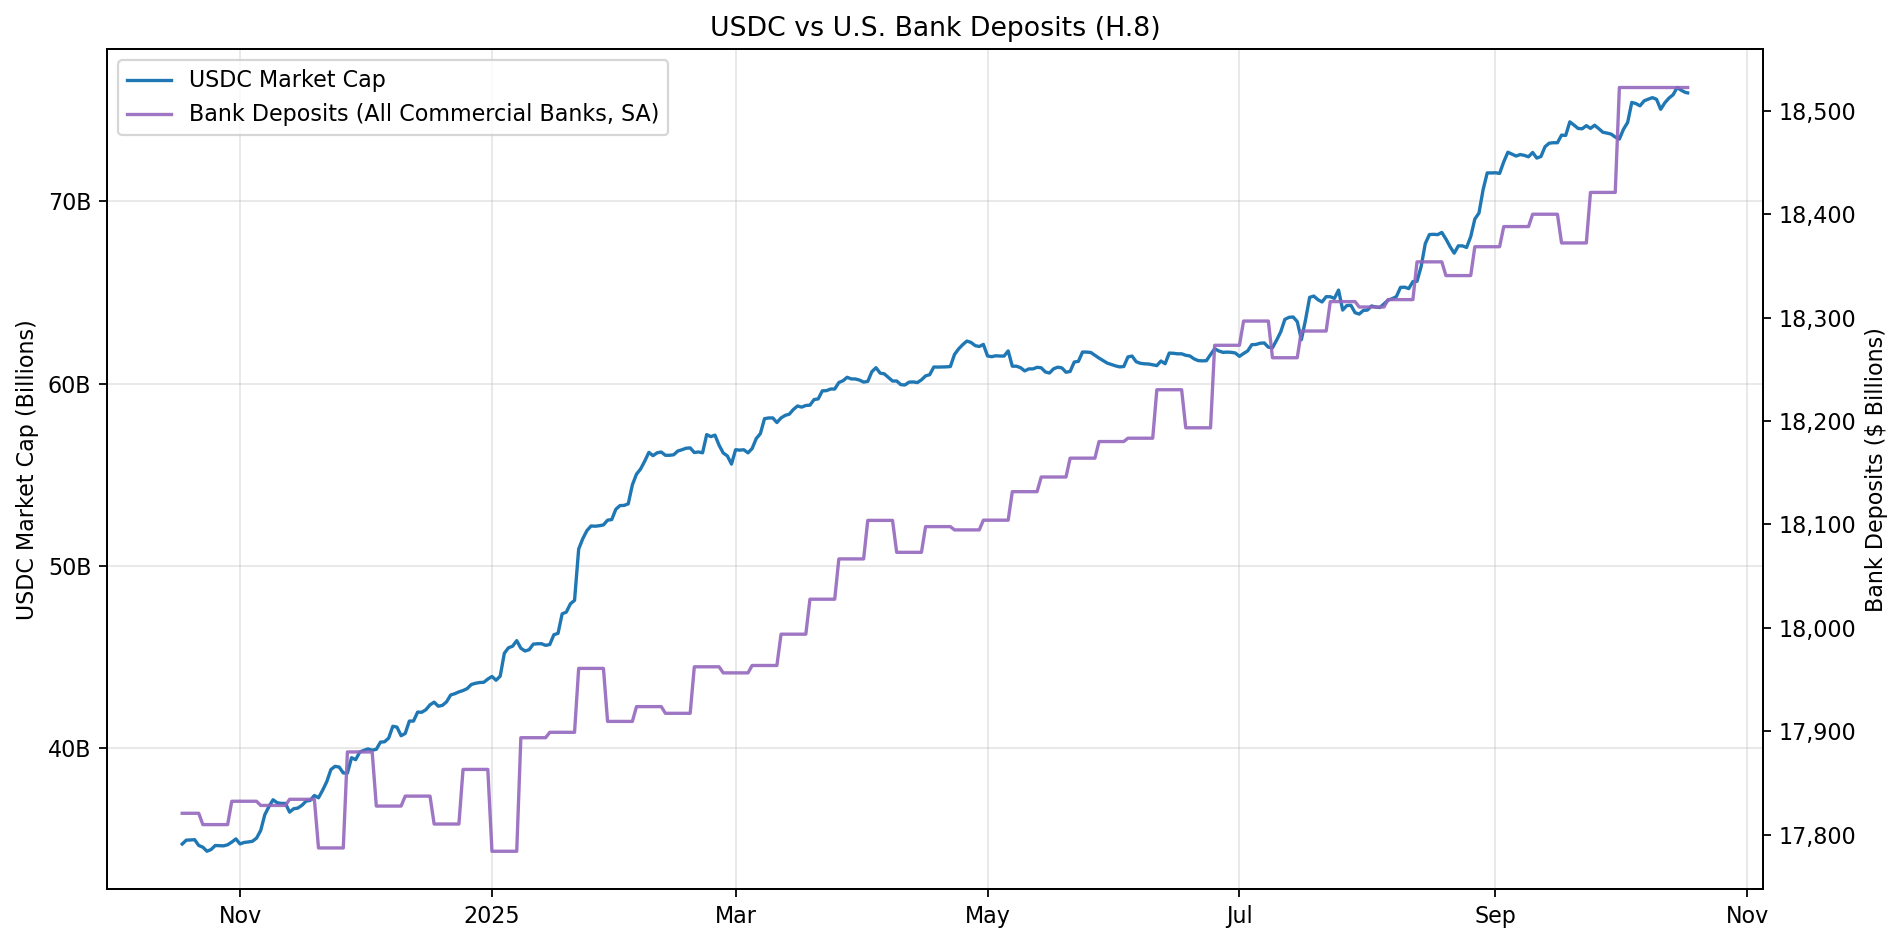

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(aligned.index, aligned["usdc_mcap"]/1e9, label="USDC Market Cap", color="#1f77b4")
ax.set_ylabel("USDC Market Cap (Billions)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}B"))

ax2 = ax.twinx()
ax2.plot(aligned.index, aligned["bank_deposits"], label="Bank Deposits (All Commercial Banks, SA)", color="#9467bd", alpha=0.9)
ax2.set_ylabel("Bank Deposits ($ Billions)")
ax2.yaxis.set_major_formatter(FuncFormatter(billions_fmt))

setup_dates(ax)
ax.set_title("USDC vs U.S. Bank Deposits (H.8)")
ax.grid(True, alpha=0.3)

# tidy legend across twin axes
lns = ax.get_lines() + ax2.get_lines()
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper left")

plt.tight_layout()
plt.savefig("viz1_usdc_vs_bank_deposits.png", dpi=180)
plt.show()

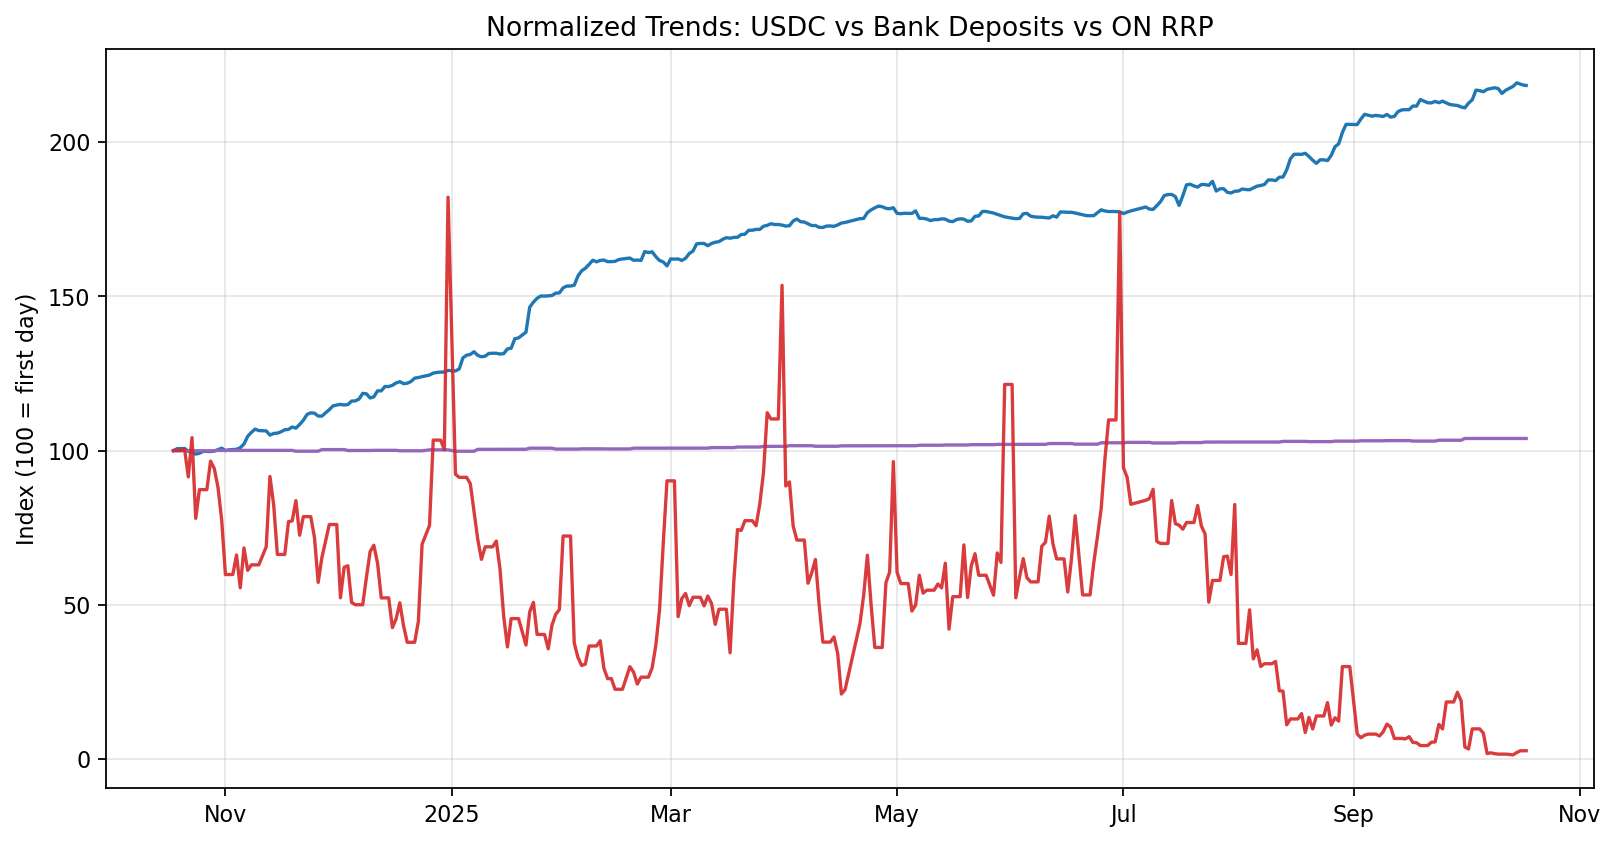

In [35]:

to_norm = aligned[["usdc_mcap","bank_deposits","on_rrp"]].dropna().copy()
norm = to_norm.apply(lambda s: 100 * s / s.iloc[0])

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(norm.index, norm["usdc_mcap"], label="USDC Market Cap (Index=100)", color="#1f77b4")
ax.plot(norm.index, norm["bank_deposits"], label="Bank Deposits (Index=100)", color="#9467bd")
ax.plot(norm.index, norm["on_rrp"], label="ON RRP (Index=100)", color="#d62728", alpha=0.9)

ax.set_title("Normalized Trends: USDC vs Bank Deposits vs ON RRP")
ax.set_ylabel("Index (100 = first day)")
setup_dates(ax)
ax.grid(True, alpha=0.3)


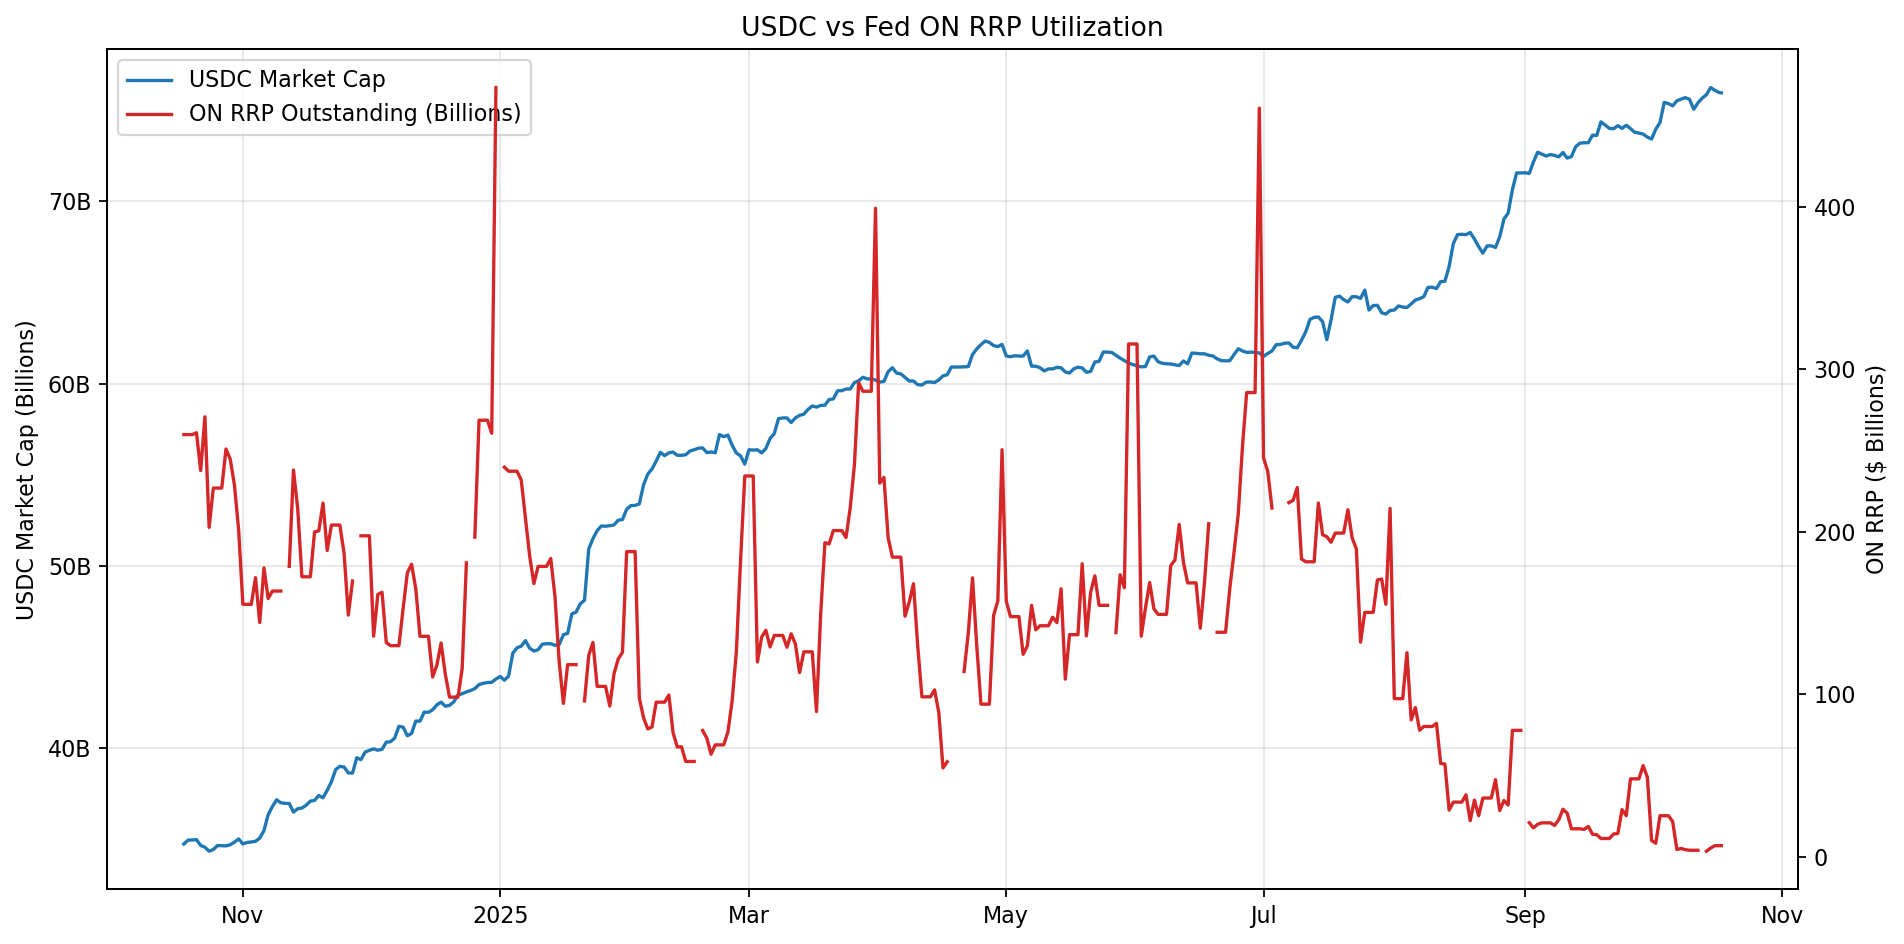

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(aligned.index, aligned["usdc_mcap"]/1e9, label="USDC Market Cap", color="#1f77b4")
ax.set_ylabel("USDC Market Cap (Billions)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}B"))

ax2 = ax.twinx()
ax2.plot(aligned.index, aligned["on_rrp"], label="ON RRP Outstanding (Billions)", color="#d62728")
ax2.set_ylabel("ON RRP ($ Billions)")

setup_dates(ax)
ax.set_title("USDC vs Fed ON RRP Utilization")
ax.grid(True, alpha=0.3)

lns = ax.get_lines() + ax2.get_lines()
ax.legend(lns, [l.get_label() for l in lns], loc="upper left")

plt.tight_layout()
plt.savefig("viz3_usdc_vs_onrrp.png", dpi=180)
plt.show()


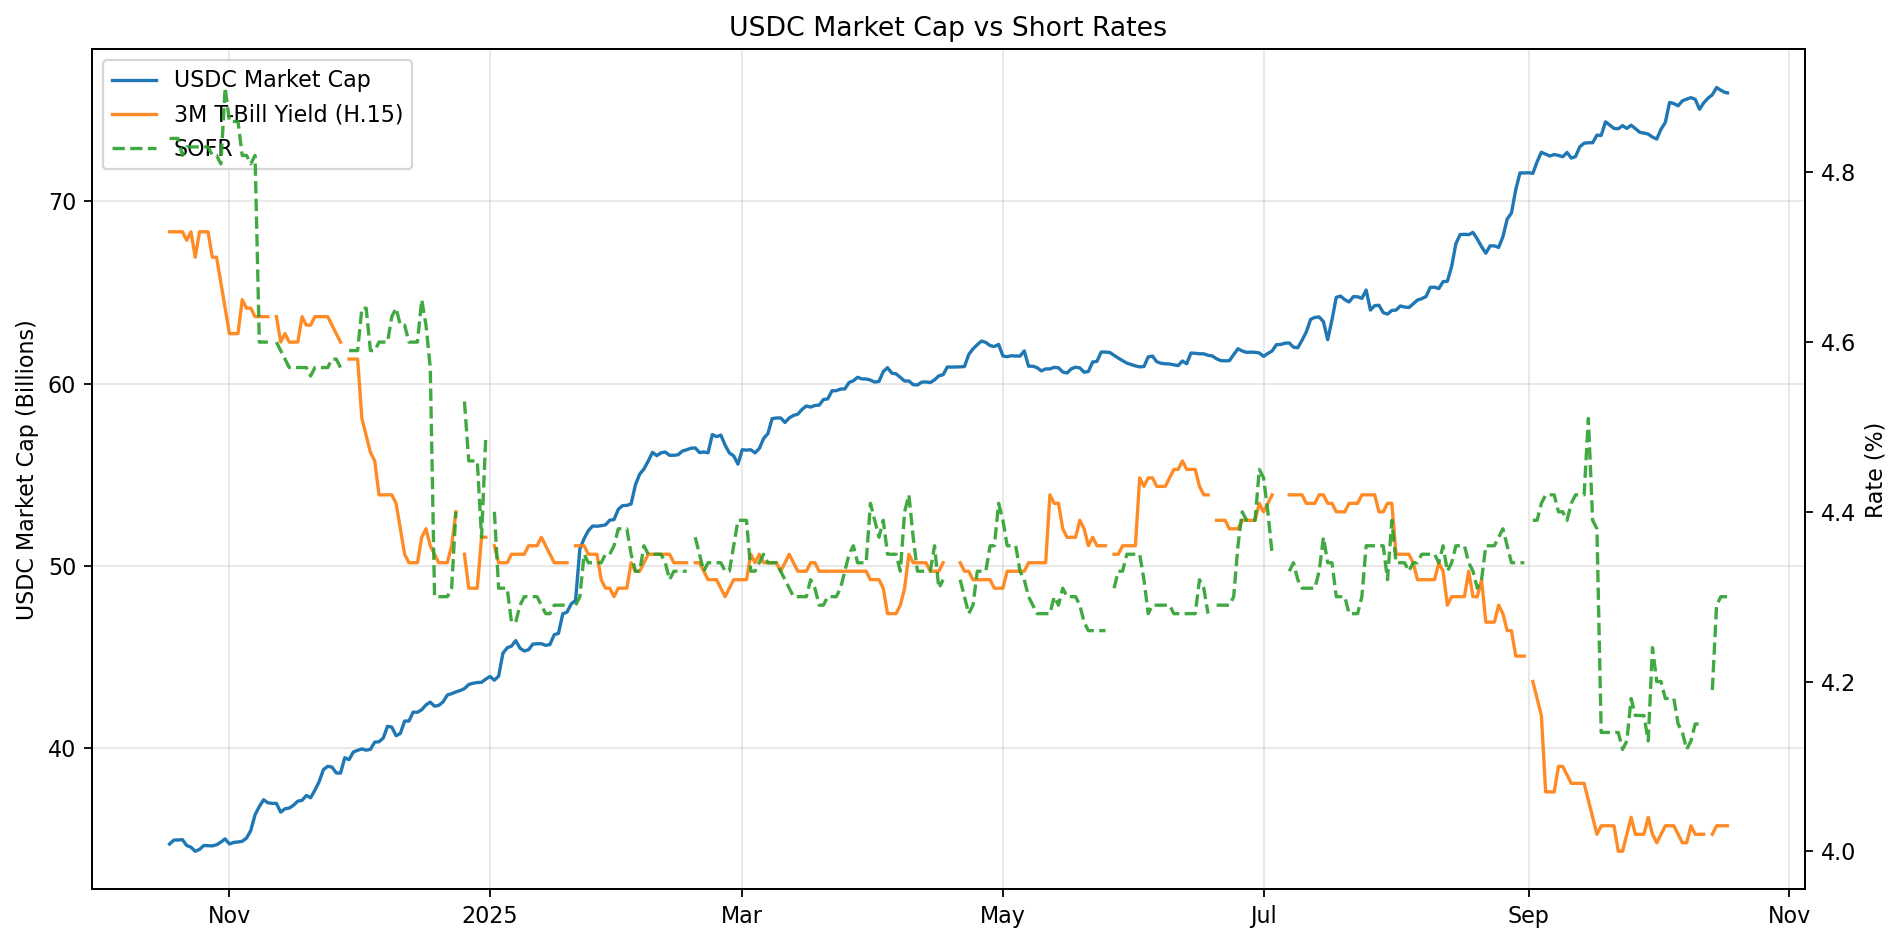

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(aligned.index, aligned["usdc_mcap"]/1e9, label="USDC Market Cap", color="#1f77b4")
ax.set_ylabel("USDC Market Cap (Billions)")

ax2 = ax.twinx()
ax2.plot(aligned.index, aligned["t3m_yield"], label="3M T-Bill Yield (H.15)", color="#ff7f0e", alpha=0.9)
ax2.plot(aligned.index, aligned["sofr"],      label="SOFR", color="#2ca02c", linestyle="--", alpha=0.9)
ax2.set_ylabel("Rate (%)")

setup_dates(ax)
ax.set_title("USDC Market Cap vs Short Rates")
ax.grid(True, alpha=0.3)

lns = ax.get_lines() + ax2.get_lines()
ax.legend(lns, [l.get_label() for l in lns], loc="upper left")

plt.tight_layout()
plt.savefig("viz4_usdc_vs_rates.png", dpi=180)
plt.show()


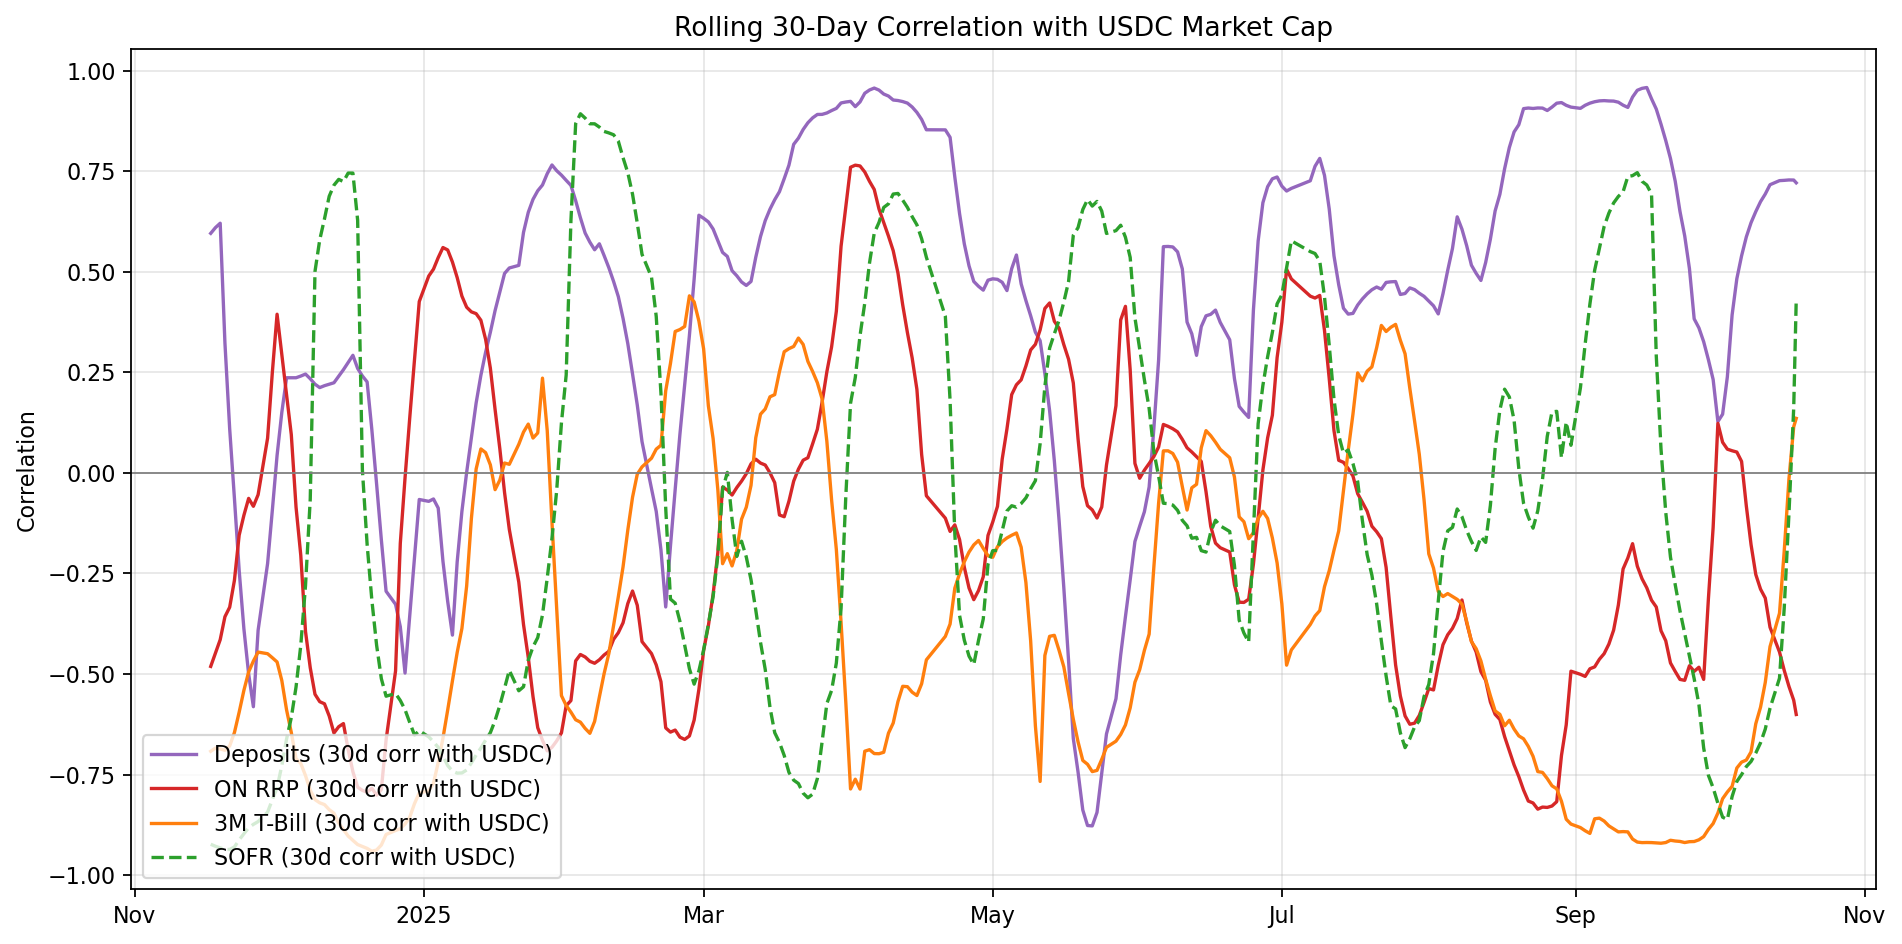

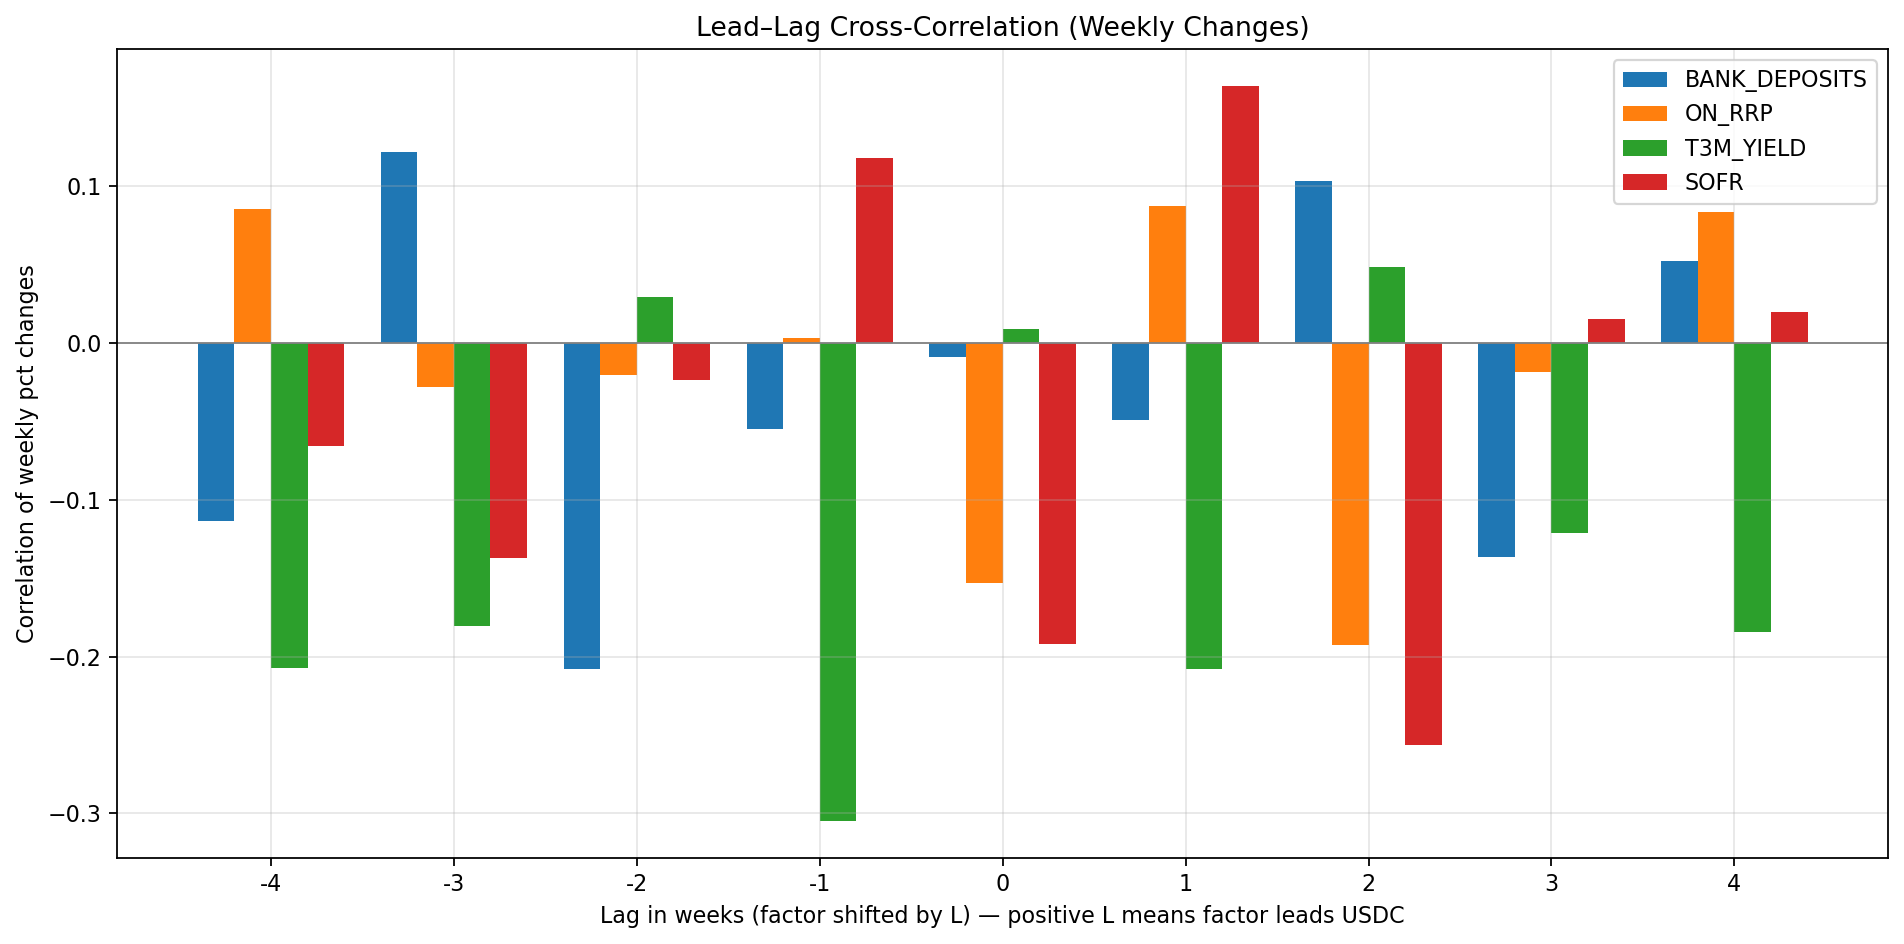

In [40]:
roll = aligned[["usdc_mcap","bank_deposits","on_rrp","t3m_yield","sofr"]].dropna().copy()
roll_30 = roll.rolling(30).corr(roll["usdc_mcap"]).drop(columns=["usdc_mcap"])

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(roll_30.index, roll_30["bank_deposits"], label="Deposits (30d corr with USDC)", color="#9467bd")
ax.plot(roll_30.index, roll_30["on_rrp"],        label="ON RRP (30d corr with USDC)", color="#d62728")
ax.plot(roll_30.index, roll_30["t3m_yield"],     label="3M T-Bill (30d corr with USDC)", color="#ff7f0e")
ax.plot(roll_30.index, roll_30["sofr"],          label="SOFR (30d corr with USDC)", color="#2ca02c", linestyle="--")

ax.axhline(0, color="gray", lw=0.8)
ax.set_title("Rolling 30‑Day Correlation with USDC Market Cap")
ax.set_ylabel("Correlation")
setup_dates(ax)
ax.grid(True, alpha=0.3)
ax.legend(loc="lower left")
plt.tight_layout()
plt.savefig("viz5_rolling_correlation.png", dpi=180)
plt.show()

# Lead-lag cross-correlation on weekly deltas
weekly = aligned[["usdc_mcap","bank_deposits","on_rrp","t3m_yield","sofr"]].resample("W").last()
d = weekly.pct_change().rename(columns=lambda c: f"d_{c}")

lags = range(-4, 5)  # in weeks (−4 to +4)
targets = ["d_bank_deposits","d_on_rrp","d_t3m_yield","d_sofr"]
xcor = {t: [] for t in targets}

for L in lags:
    for t in targets:
        s1 = d["d_usdc_mcap"]
        s2 = d[t].shift(L)  # positive L tests whether factor LEADS USDC by L weeks
        xcor[t].append(s1.corr(s2))

import numpy as np
x = np.arange(len(lags))
width = 0.2

fig, ax = plt.subplots(figsize=(12,6))
for i, t in enumerate(targets):
    ax.bar(x + i*width - (1.5*width), xcor[t], width, label=t.replace("d_","").upper())

ax.set_xticks(x)
ax.set_xticklabels([str(L) for L in lags])
ax.set_xlabel("Lag in weeks (factor shifted by L) — positive L means factor leads USDC")
ax.set_ylabel("Correlation of weekly pct changes")
ax.axhline(0, color="gray", lw=0.8)
ax.set_title("Lead–Lag Cross‑Correlation (Weekly Changes)")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("viz6_lead_lag_bars.png", dpi=180)
plt.show()


In [42]:

print("Latest observations:")
print(aligned.tail(1).to_string())

# Friendly units
last = aligned.tail(1).copy()
last["usdc_mcap_B"] = last["usdc_mcap"] / 1e9
print(last[["usdc_mcap_B","bank_deposits","t3m_yield","sofr","on_rrp"]])


Latest observations:
                        usdc_mcap  bank_deposits  t3m_yield  sofr  on_rrp
date                                                                     
2025-10-17 12:48:56  7.592714e+10     18522.3097       4.03   4.3    6.96
                     usdc_mcap_B  bank_deposits  t3m_yield  sofr  on_rrp
date                                                                    
2025-10-17 12:48:56    75.927142     18522.3097       4.03   4.3    6.96


In [56]:
#Create a summary and captions for the visualizations
import pandas as pd
import numpy as np

# Format a number as a percentage string with two decimal places
def human_pct(x):
    try:
        return f"{x:.2f}%"
    except:
        return "n/a"

# Calculate percentage changes over different time spans (1D, 1M, 3M, 6M)
def span_changes(s: pd.Series, months=[1, 3, 6]):
    out = {}
    last = s.dropna().iloc[-1]  # Most recent non-null value
    out["last"] = last
    out["d1d"]  = s.pct_change().dropna().iloc[-1] * 100  # 1-day change

    # Approximate month-over-month changes using 30-day intervals
    for m in months:
        prior = s.asfreq("D").dropna()  # Ensure daily frequency
        prior = prior.reindex(prior.index)  # Reindex to enforce daily index
        prior_val = prior.shift(30*m).reindex(s.index).iloc[-1]  # Value from m months ago
        out[f"d{m}m"] = (last/prior_val - 1) * 100 if pd.notna(prior_val) and prior_val != 0 else np.nan
    return out
# Generate a human-readable summary of a time series
def describe_series(name, s, unit="", to_billions=False):
    _s = s.copy()
    if to_billions:
        _s = _s / 1e9  # Convert to billions if needed
    ch = span_changes(_s)  # Get change metrics
    return (
        f"{name}: {ch['last']:.2f}{unit} "
        f"(1D {human_pct(ch['d1d'])}, 1M {human_pct(ch['d1m']) if 'd1m' in ch else 'n/a'}, "
        f"3M {human_pct(ch['d3m']) if 'd3m' in ch else 'n/a'}, "
        f"6M {human_pct(ch['d6m']) if 'd6m' in ch else 'n/a'})."
    )

# Compute correlation matrix of weekly percentage changes
def correlations_table(df):
    wk = df.resample("W").last().pct_change()  # Weekly % changes
    corr = wk.corr().round(3)  # Round for readability
    return corr

# Analyze lead-lag relationships between a target and multiple factors
def lead_lag(df, target="usdc_mcap", factors=("bank_deposits","on_rrp","t3m_yield","sofr"), max_lag_weeks=4):
    wk = df.resample("W").last().pct_change()  # Weekly % changes
    res = {}
    for f in factors:
        series_corr = []
        for L in range(-max_lag_weeks, max_lag_weeks+1):  # Test lags from -4 to +4 weeks
            c = wk[target].corr(wk[f].shift(L))  # Correlation with lag
            series_corr.append((L, c))
        best = max(series_corr, key=lambda t: abs(t[1]) if t[1] is not None else -1)  # Best correlation by magnitude
        res[f] = {"best_lag_weeks": best[0], "corr": best[1]}
    return res

# Create caption for USDC vs Bank Deposits chart
def make_caption_usdc_vs_deposits(aligned):
    cap = []
    cap.append("**Figure 1 – USDC vs U.S. Bank Deposits (H.8):**")
    cap.append(describe_series("USDC Market Cap (B$)", aligned["usdc_mcap"], unit="B", to_billions=True))
    cap.append(describe_series("Bank Deposits (All Commercial Banks, $B)", aligned["bank_deposits"], unit="B"))
    return " ".join(cap)

# Create caption for USDC vs ON RRP chart
def make_caption_usdc_vs_onrrp(aligned):
    cap = []
    cap.append("**Figure 3 – USDC vs Fed ON RRP:**")
    cap.append(describe_series("USDC Market Cap (B$)", aligned["usdc_mcap"], unit="B", to_billions=True))
    cap.append(describe_series("ON RRP Outstanding (B$)", aligned["on_rrp"], unit="B"))
    return " ".join(cap)

# Create caption for USDC vs interest rates chart
def make_caption_usdc_vs_rates(aligned):
    cap = []
    cap.append("**Figure 4 – USDC vs Short Rates (SOFR, 3M T‑bill):**")
    cap.append(describe_series("USDC Market Cap (B$)", aligned["usdc_mcap"], unit="B", to_billions=True))
    cap.append(describe_series("3M T‑bill (%)", aligned["t3m_yield"], unit="%"))
    cap.append(describe_series("SOFR (%)", aligned["sofr"], unit="%"))
    return " ".join(cap)

# ---- RUN THE SUMMARIES ----

# Print latest values in friendly units
print("=== Latest values (friendly units) ===")
last = aligned.tail(1).copy()
last["usdc_mcap_B"] = last["usdc_mcap"] / 1e9  # Convert USDC market cap to billions
print(last[["usdc_mcap_B","bank_deposits","t3m_yield","sofr","on_rrp"]].to_string())

# Print draft captions for figures
print("\n=== Figure captions (draft) ===")
print(make_caption_usdc_vs_deposits(aligned))
print(make_caption_usdc_vs_onrrp(aligned))
print(make_caption_usdc_vs_rates(aligned))

# Print correlation matrix of weekly % changes
print("\n=== Correlations (weekly % changes) ===")
corr = correlations_table(aligned[["usdc_mcap","bank_deposits","on_rrp","t3m_yield","sofr"]])
print(corr)

# Print best lead/lag correlations for USDC vs other factors
print("\n=== Lead/Lag best correlations (weekly % changes) ===")
print(lead_lag(aligned, target="usdc_mcap",
               factors=("bank_deposits","on_rrp","t3m_yield","sofr"),
               max_lag_weeks=4))

=== Latest values (friendly units) ===
                     usdc_mcap_B  bank_deposits  t3m_yield  sofr  on_rrp
date                                                                    
2025-10-17 12:48:56    75.927142     18522.3097       4.03   4.3    6.96

=== Figure captions (draft) ===
**Figure 1 – USDC vs U.S. Bank Deposits (H.8):** USDC Market Cap (B$): 75.93B (1D -0.03%, 1M nan%, 3M nan%, 6M nan%). Bank Deposits (All Commercial Banks, $B): 18522.31B (1D 0.00%, 1M nan%, 3M nan%, 6M nan%).
**Figure 3 – USDC vs Fed ON RRP:** USDC Market Cap (B$): 75.93B (1D -0.03%, 1M nan%, 3M nan%, 6M nan%). ON RRP Outstanding (B$): 6.96B (1D 0.00%, 1M nan%, 3M nan%, 6M nan%).
**Figure 4 – USDC vs Short Rates (SOFR, 3M T‑bill):** USDC Market Cap (B$): 75.93B (1D -0.03%, 1M nan%, 3M nan%, 6M nan%). 3M T‑bill (%): 4.03% (1D 0.00%, 1M nan%, 3M nan%, 6M nan%). SOFR (%): 4.30% (1D 0.00%, 1M nan%, 3M nan%, 6M nan%).

=== Correlations (weekly % changes) ===
               usdc_mcap  bank_deposits  on_rrp

C:\Users\Raghav\AppData\Local\Temp\ipykernel_12832\1596712462.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  out["d1d"]  = s.pct_change().dropna().iloc[-1] * 100  # 1-day change


In [2]:
#Get Crypto related legislation for analysis
#Enter your API key here
API_KEY = "Y7ErEWj1Ng4cf1vidPOMLdJpvmbOodZE2Bglr4W8"

os.environ['FRED_API_KEY'] = 'c08c9d0010eed7b1c3fb87be96436121'
# Step 2: Choose a specific bill keyword
query = "GENIUS Act OR CLARITY Act OR Anti-CBDC"






In [58]:
# List of crypto-related bills with direct links to full text for analysis
bills = {
    "GENIUS Act (S.1582)": "https://www.congress.gov/bill/119th-congress/senate-bill/1582/text",
    "Digital Asset Market Clarity Act (H.R.3633)": "https://www.congress.gov/bill/119th-congress/house-bill/3633/text",
    "Anti-CBDC Surveillance State Act (H.R.1919)": "https://www.congress.gov/bill/119th-congress/house-bill/1919/text"
}

# Display bill titles and links
for title, url in bills.items():
    print(f"{title}\nFull Text: {url}\n{'-'*80}")

GENIUS Act (S.1582)
Full Text: https://www.congress.gov/bill/119th-congress/senate-bill/1582/text
--------------------------------------------------------------------------------
Digital Asset Market Clarity Act (H.R.3633)
Full Text: https://www.congress.gov/bill/119th-congress/house-bill/3633/text
--------------------------------------------------------------------------------
Anti-CBDC Surveillance State Act (H.R.1919)
Full Text: https://www.congress.gov/bill/119th-congress/house-bill/1919/text
--------------------------------------------------------------------------------
